In [1]:
import os, sys
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from fftlog.sbt import SBT

# Showcasing Spherical Bessel Transform (SBT)

Here is a test function `pk`
- the function should go asymptotically to 0 on the left and the right as the FFTLog will transform the function into a periodic one. 

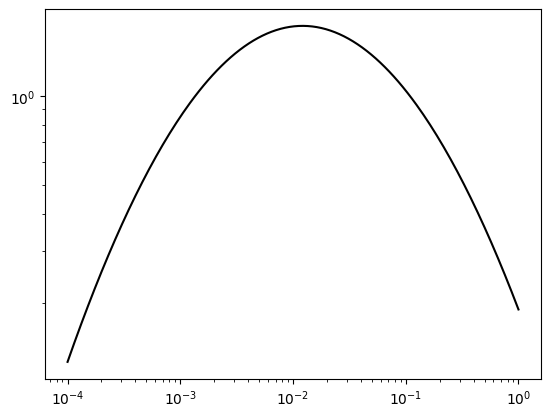

In [2]:
kk = np.logspace(-4, 0, 200)
pk = lognorm.pdf(kk, 2.1) 

plt.plot(kk, pk, 'k')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [3]:
sbt = SBT(to_fourier=False, ells=[0, 2])

In [4]:
xi = sbt.get_transform(kk, pk)

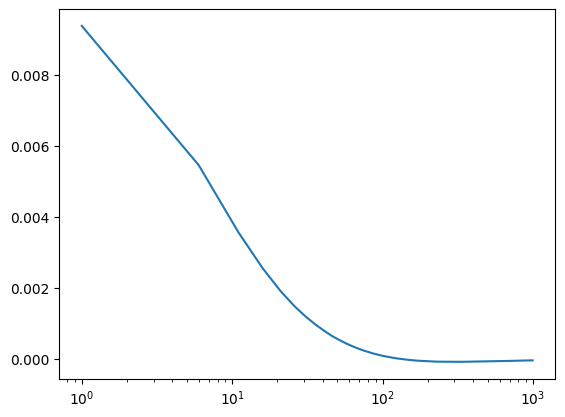

In [5]:
plt.plot(sbt.x, sbt.x**2 * xi[0])
plt.xscale('log')